# ZRE Projekt 2022 — Spektra a RELP
### Alexander Polok
### xpolok03@fit.vutbr.cz

In [126]:
import numpy as np
import soundfile as sf
from IPython.display import Audio
import lib
import plots
import importlib

importlib.reload(lib)
importlib.reload(plots)

<module 'plots' from '/home/lakoc/FIT/1MIT/summer/ZRE/project/plots.py'>

# Úloha 1 - základy - 2 body
Načtěte řečový signál z https://www.fit.vutbr.cz/study/courses/ZRE/public/2021-22/a.wav (použijte vhodnou knihovnu ke čtení WAVek). Odečtěte střední hodnotu (tím se zbavíte stejnosměrné složky). Rozdělte jej na
rámce o délce 20 ms s nulovým překrytím (budou tedy těsně navazovat jeden na druhý). Vyberte pěkný znělý rámec, zobrazte ho a ručně určete periodu základního tónu ve vzorcích a v sekundách.

In [127]:
!wget https://www.fit.vutbr.cz/study/courses/ZRE/public/2021-22/a.wav
!wget https://www.fit.vutbr.cz/study/courses/ZRE/public/2021-22/features.py

In [128]:
# Load input file
sig, Fs = sf.read('a.wav')
Audio(sig, rate=Fs)

In [129]:
# Subtract mean value from signal
print(np.mean(sig))
sig = sig - np.mean(sig)
print(np.mean(sig))

# Signal framing
win_size = int(0.02 * Fs)  # 20ms
frames = lib.split_padded(sig, np.ceil(sig.shape[0] / win_size).astype(int))

0.00041165069563321596
2.000918729178119e-18


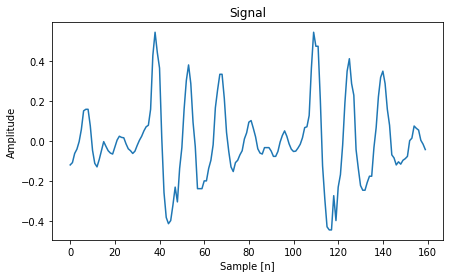

In [130]:
# Plot voiced frame
frame_to_plot = 7
frame_to_analyze = frames[frame_to_plot]
plots.plot_signal(frame_to_analyze)

### Lag is equal to (105-35) ~ 70 samples ∼ 70/Fs = 0,00875s ~ 1/70 * Fs = 114,29 Hz, which corresponds to the voice range of average man.

## Úloha 2 - spektrálnı́ hustota výkonu pomocı́ FFT - 2 body
Napište funkci pro odhad spektrálnı́ hustoty výkonu (power spectral density, PSD) pomocı́ FFT. Výstup nechť je 129 čı́sel od 0 do poloviny vzorkovacı́ frekvence (FFT tedy musı́te počı́tat na 256 vzrocı́ch - pokud je jich v rámci méně, použijte doplněnı́ nulami). Zobrazte logaritmus PSD vybraného rámce se slušnou frekvenčnı́ osou v Hz.

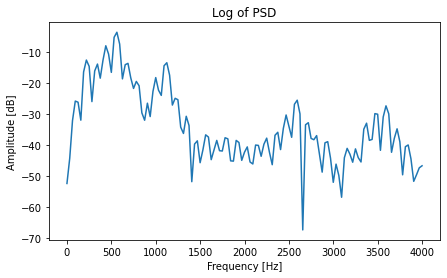

In [131]:
n_coef = 256
freq_to_show = 129
freq = np.linspace(0, Fs / 2, freq_to_show)

# Calculate power spectral density
psd = lib.psd_fft(frame_to_analyze, win_size, n_coef)[:freq_to_show]
psd_fft = 10 * np.log10(psd)
# Plot log of it from 0 to Fs/2
plots.plot_psd(psd_fft, freq)


## Úloha 3 - Odhad sady LPC filtrů - 2 body
Napište funkci pro odhad LPC filtru reprezentujı́ho daný rámec pomocı́ algoritmu Levinsona Durbina. Zajı́majı́
nás všechny filtry od řádu P = 1 až po P = 20. Nezapomeňte pro kažý filtr uložit i gain.

In [132]:
P = 10
A, G = lib.lpc(frame_to_analyze, P=P)

## Úloha 4 - analýza sady LPC filtrů - 2 body
Proveďte LPC analýzu vybraného znělého rámce pomocı́ všech LPC filtrů. Pro každý vygenerujte chybový signál lineárnı́ predikce e[n]. Spočı́tejte jeho energii. Ukažte závislost energie chybového signálu na řádu prediktoru. Ověřte že P = 10 je “rozumný” řád prediktoru.

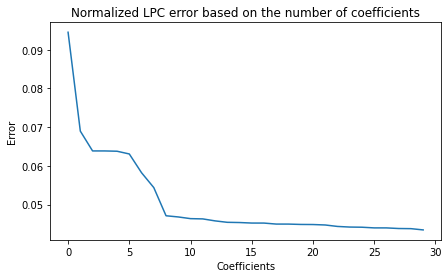

Error difference between 31 and 10 coefficients: 0.0033494026350408823


In [133]:
max_coefficients = 31
errors = [lib.lpc(frame_to_analyze, P=i)[1] for i in range(1, max_coefficients)]
plots.plot_lpc_errors(errors)

print(f'Error difference between {max_coefficients} and 10 coefficients: {errors[9] - errors[max_coefficients - 2]}')

## Úloha 5 - spektrálnı́ hustota výkonu pomocı́ LPC - 2 body
Napište funkci pro odhad spektrálnı́ hustoty výkonu (power spectral density, PSD) pomocı́ LPC filtru a jeho gainu. Výstup nechť je opět 129 čı́sel od 0 do poloviny vzorkovacı́ frekvence. Zobrazte logaritmus PSD vybraného rámce pro vybraný řád filtru se slušnou frekvenčnı́ osou.

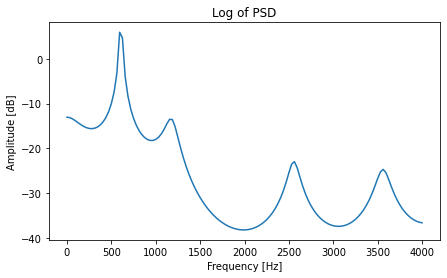

In [134]:
# Add 0th filter coefficient
A = np.append(1.0, A[:-1])
psd_lpc = 10 * np.log10(lib.psd_lpc(A, G, freq_to_show))
plots.plot_psd(psd_lpc, freq)

## Úloha 6 - spektrálnı́ hustota výkonu pomocı́ Mel banky filtrů - 2 body
Napište funkci pro odhad spektrálnı́ hustoty výkonu (power spectral density, PSD) pomocı́ Mel-banky filtrů s 23 filtry. Výstup nechť je opět 129 čı́sel od 0 do poloviny vzorkovacı́ frekvence. Zobrazte logaritmus PSD vybraného rámce se slušnou frekvenčnı́ osou. Využijte funkce z knihovny pytel2 .

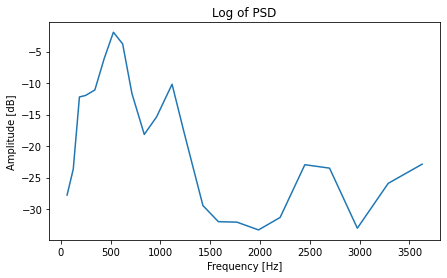

In [135]:
psd_mel, mel_freq = lib.psd_mel(frame_to_analyze, w_size=win_size, nfft=n_coef, Fs=Fs, show_freq=freq_to_show,
                                n_banks=23)
psd_mel = 10 * np.log10(psd_mel)
plots.plot_psd(psd_mel, mel_freq)

## Úloha 7 - Srovnánı́ PSD - 2 body
Ukažte (stále na vybraném rámci) všechny vypočı́tané PSD (pomocı́ FFT, Mel-banky filtrů a LPC pro alespoň 5 různých řádů filtrů) v jednom obrázku. Pokud “nesedı́” jejich úrovně, srovnejte je buď teoreticky (úprava gainů, atd.) nebo experimentálně. Komentujte frekvenčnı́ rozlišenı́ jednotlivých metod. Uveďte, kde vidı́me vliv hlasivek a kde artikulačnı́ho ústrojı́.

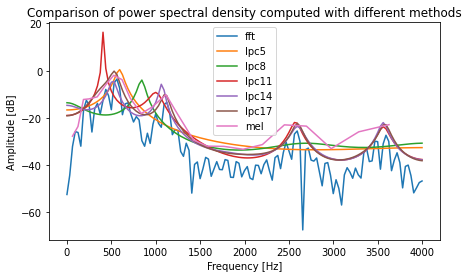

In [136]:
def get_lpc_psd(A):
    A = np.append(1.0, A[:-1])
    psd_lpc = 10 * np.log10(lib.psd_lpc(A, G, freq_to_show))
    return psd_lpc


lpc_psds = [(get_lpc_psd(lib.lpc(frame_to_analyze, P=i)[0]), f'lpc{i}') for i in range(5, 18, 3)]
plots.plot_psd_variants((freq, psd_fft), (freq, lpc_psds), (mel_freq, psd_mel))

### V spektralní hustotě výkonu vytvořené přímo z výstupu FFT je možné detekovat periodické prvky, které odpovídají základní frekvenci mluvy. Vliv hlasivek je tedy naprosto patrný na tvaru této křivky. Naopak LPC a MFCC modelují artikulační ústrojí a vliv hlasivek by tedy neměl být viditelný.
### Jelikož MFCC jsou spočteny pouze na 23 bankách je frekvenční rozlišení velmi nízké a dokonce není definované ani na celém intervalu, byla by nutná interpolace. Frekvenční rozlišení LPC a FFT PSD je stejné, na ose X se nachází 129 hodnot.


## Úloha 8 - RELP - jen krátkodobá predikce - 5 bodů
Vytvořte funkci pro kódovánı́ – tvorbu signálu chyby lineárnı́ predikce (“residual”) pro celou nahrávku, po 20 ms budete měnit LPC koeficienty. Dejte pozor, abyste ve filtru A(z) neresetovali počátečnı́ podmı́nky, ale použili je z minulého rámce (prostudujte help k přı́slušné filtrovacı́ funkci nebo si ji napište sami). Zobrazte reziduál pro vybraný rámec, měli byste jasně vidět, že krátkodobé korelace (“vlnky”) vzniklé dı́ky rezonancı́m hlasového traktu v něm zmizely.

Vytvořte funkci pro dekódovánı́ – generovánı́ řeči z reziduálu pro celou nahrávku, po 20 ms budete měnit LPC 1 koeficienty. Dejte pozor, abyste ve filtru A(z) neresetovali počátečnı́ podmı́nky, ale použili je z minulého rámce (prostudujte help k přı́slušné filtrovacı́ funkci nebo si ji napište sami).

Vygenerujte signál po průchodu takovým kodekem a ověřte, že je shodný s originálem.

## Úloha 9 - RELP - včetně základnı́ho tónu - 5 bodů
Pokud se podı́váte na reziduál z úlohy 8, stále v něm uvidite “rány” způsobené hlasivkami, které se periodicky opakujı́. Výsledný reziduál tak nenı́ úplně vhodný na kódovánı́. V této úloze se jej pokuste dále “vybělit” (tak, aby se co nejvı́ce podobal bı́lému šumu) pomocı́ znalosti o periodě základnı́ho tónu. Můžete postupovat různě:
1. Odhadněte periodu základnı́ho tónu (viz cvičenı́) a analogicky ke krátkodobému prediktoru A(z) = 1 + a_{1}z^{−1} . . . a_{10}z^{−10} implementujte dlouhodobý prediktor B(z) = 1 + b_{1}z^{−L}, kde L je perioda základnı́ho tónu ve vzorcı́ch (lag). Koeficient b1 můžete natvrdo nastavit na 1, odvodit/najı́t vzoreček pro jeho výpočet, nebo najı́t dobrou hodnotu hrubou silou pomocı́ minimalizace energie “druhého” reziduálu po průchodu tı́mto filtrem.
2. Dlouhodobý prediktor B(z) můžete udělat i složitějšı́ s vı́ce koeficienty.
3. V historii krátkodobého reziduálu (na výstupu A(z)) pomocı́ korelace najı́t nejpodobnějšı́ úsek, zapamatovat si, jak daleko v historii je (pro znělé hlásky bude “jak daleko v historii je” odpovı́dat L!) a odečı́st ho.

Zı́skáte “druhý” reziduál. Zobrazte jej pro vybraný rámec a zkontrolujte, že je “bělějšı́” než ten krátkodobý.

Připravte si také funkci pro dekódovánı́ řeči (pro možnost 1 nebo 2 to bude filtrovánı́ filtrem 1/B(z), pro 3 přičtenı́ “druhého” reziduálu ke správnému úseku v historii).

Vygenerujte signál po průchodu takovým kodekem a ověřte, že je shodný s originálem.

## Úloha 10 - RELP s kvantovánı́m - 5 bodů
Úkol je jednoduchý: stlačit počet bitů potřebných k zakódovánı́ celé nahrávky na minimum. Můžete použı́ cokoliv - jiné LPC parametry (PARCOR, LAR, LSF, cokoliv...), vektorové kvantovánı́, kvantovánı́ reziduálu nı́zkým počtem bitů, atd.

Popište, co jste dělali a jak nı́zko jste se dostali, aby byla nahrávka stále  rozumitelná. Do odevzdaného tgz dejte výslednou nahrávku a do protokolu počet bitů.

Nemusı́te implementovat bitové operace, pokud např. vı́te, že LPC koeficienty kvantujete VQ s kódovou knihou o velikosti 1024, gain skalárně na 4 bitech, lag na 8 bitech a reziduál na 1 bitu na vzorek, stačı́ počet bitů spočı́tat jako `Nr × (10 + 4 + 8 + 160 × 1)`, kde Nr je počet rámců.